# Objectif

Classifier les 3ème, 4ème et 5ème signaux de chaque ensemble de signaux présent dans un dossier

Voici les catégories : 
- Pics
- Bruit
- Robot

# Import

In [1]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

import os
import shutil


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

import scipy
from scipy.signal import find_peaks

import inspect
from tqdm import tqdm


# Importer les signaux

In [2]:
def get_data_from_file(filepath, seq_len):
    data = scipy.io.loadmat(filepath)
    return data['voltage'][0][:seq_len].astype(np.float64), data['current'][0][:seq_len].astype(np.float64), data['f1'][0][:seq_len].astype(np.float64), data['f2'][0][:seq_len].astype(np.float64), data['f3'][0][:seq_len].astype(np.float64)


def generate_data(dossier, seq_len=1900, nb_channel=5):

    data = []
    
    for file in os.listdir(dossier):
        filepath = os.path.join(dossier, file)
        if os.path.isfile(filepath):
            data_v, data_c, data_f1, data_f2, data_f3 = get_data_from_file(filepath, seq_len)
            list_data_from_file = [data_v, data_c, data_f1, data_f2, data_f3]

            data.append(list_data_from_file)

    nb_files = len(data)
    return np.array(data).reshape(nb_files, nb_channel, 1, seq_len)

In [3]:
folder_path = "Cluster Signaux/phase_sinus"

In [4]:
seq_len = 1900

In [5]:
data_echantillon = generate_data(folder_path, seq_len=seq_len)

In [6]:
data_echantillon.shape

(1977, 5, 1, 1900)

# Affichage

In [7]:
def affichage_data(signal, seq_len=1900, nb_channels=5, info_text="Signal"):
    # Diviser le plot en 5 parties
    fig, axs = plt.subplots(nb_channels, 1, figsize=(20, 8), sharex=True)

    # Affichage du signal réel
    for i in range(nb_channels):
        axs[i].plot(signal[i].reshape(seq_len), label=f'Signal {i+1}')
        axs[i].grid()
    
    plt.suptitle(info_text)
    plt.show()

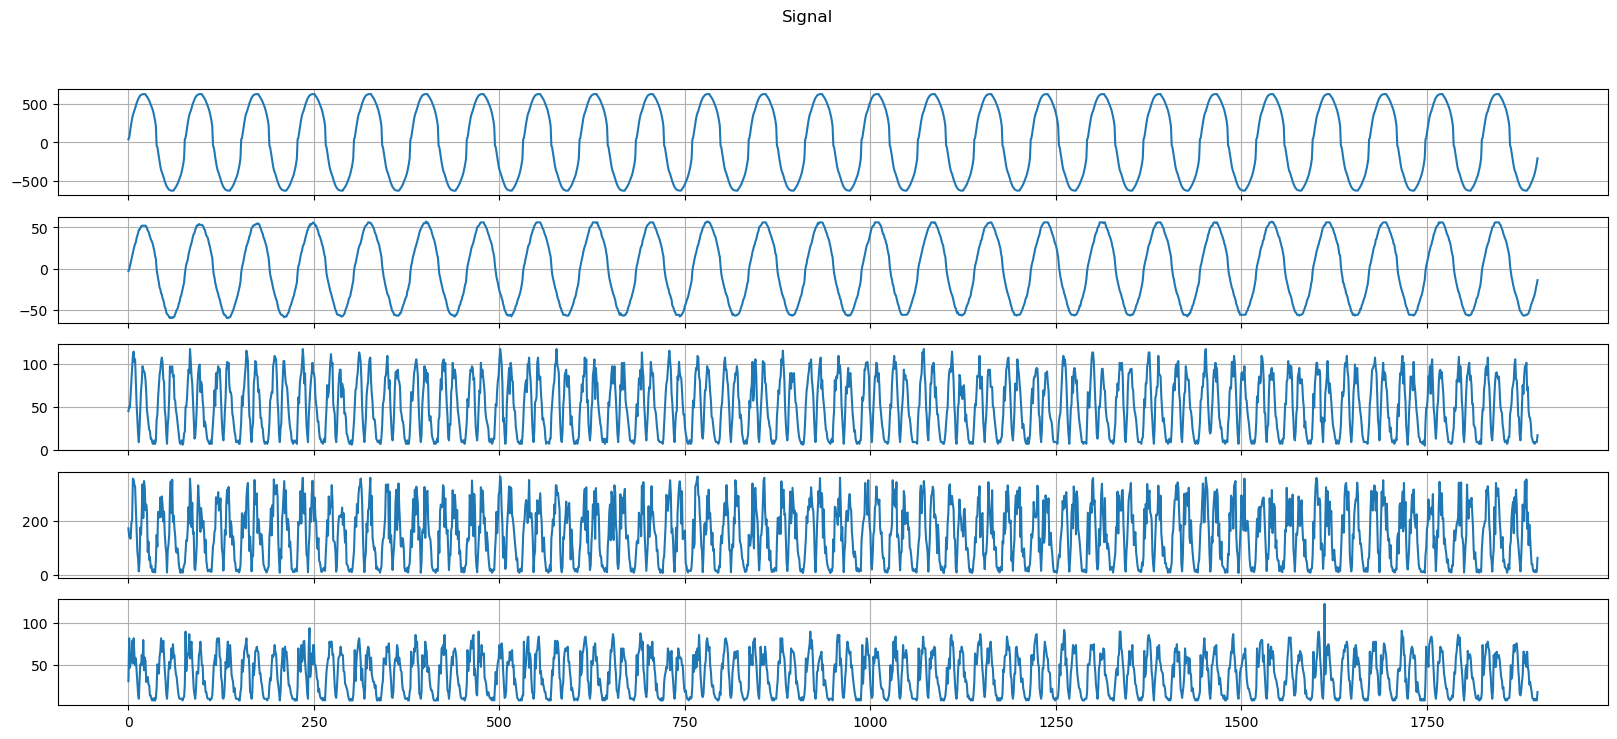

In [19]:
indice = np.random.randint(0, data_echantillon.shape[0])
affichage_data(data_echantillon[indice])

# Calcule de la norme (sur 1 pour le test)

In [613]:
def calculate_norms(array):
    
    selected_rows = array[2:5]

    norms = []

    for row in selected_rows:
        norm = np.linalg.norm(row)
        data_normalized = row / norm
        norms.append(data_normalized)
    
    return norms

In [614]:
def get_type(norms):
    values_means = []

    for norm in norms:
        values_means.append(np.mean(sorted(norm[0], reverse=True)[:10]))

    # print(values_means)
    type = ""
    
    for value_mean in values_means:
        if value_mean > 0.065:
            type += "P"
        elif value_mean < 0.035:
            type += "R"
        else:
            type += "B"
    
    return type

RRR


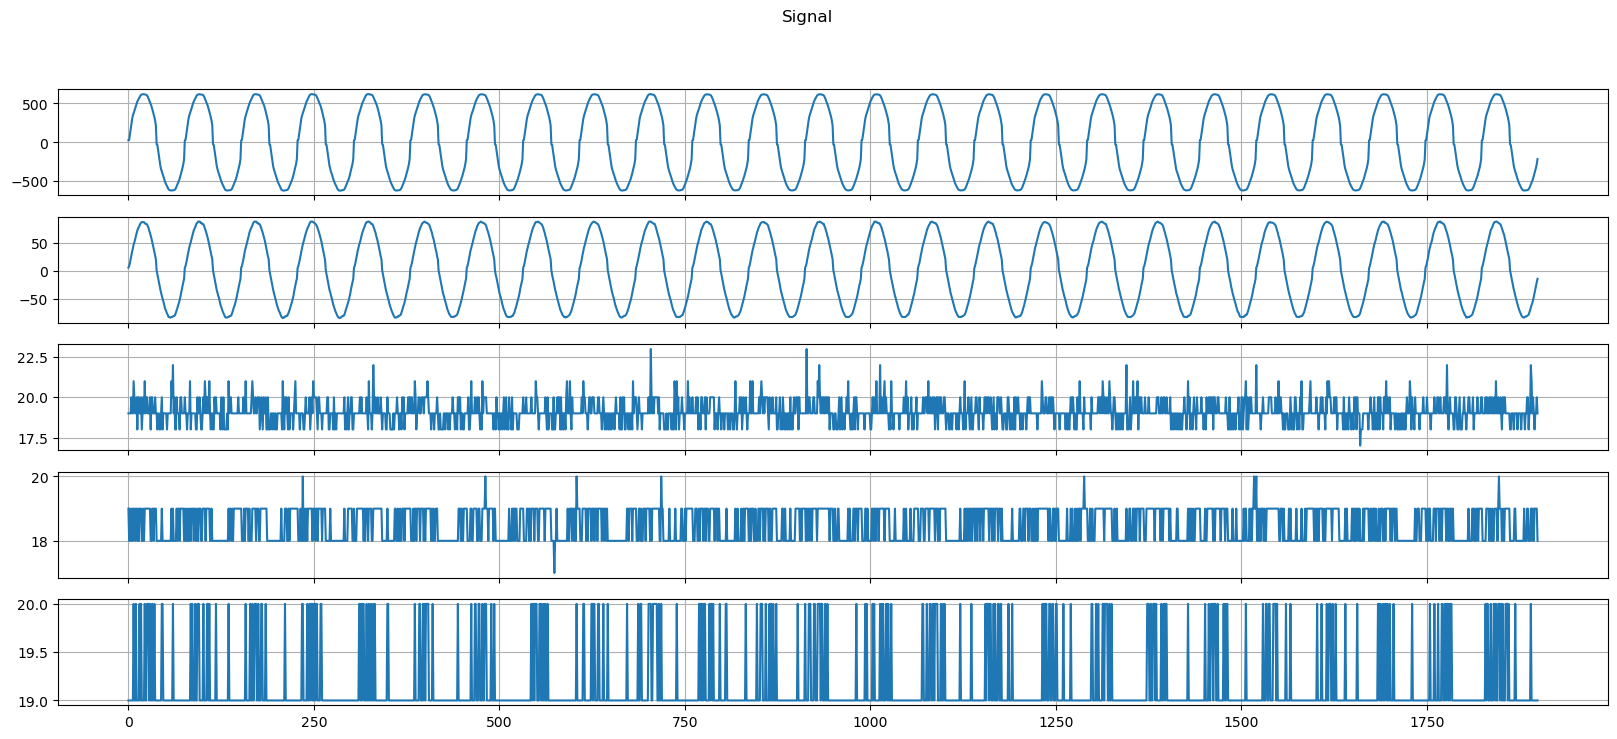

In [624]:
indice = np.random.randint(0, data_echantillon.shape[0])

norms = calculate_norms(data_echantillon[indice])
type = get_type(norms)

print(type)

affichage_data(data_echantillon[indice])

# Calcule de la norme (sur tous les données d'un dossier)

In [625]:
def sauvegarde_signaux(list_signaux, nom_signaux, save_dir):

    if os.path.exists(save_dir) == False:
        os.mkdir(save_dir)
        
    
    list_signaux = np.squeeze(list_signaux)

    data = {
        'voltage': list_signaux[0],
        'current': list_signaux[1],
        'f1': list_signaux[2],
        'f2': list_signaux[3],
        'f3': list_signaux[4],
    }

    indice_mat = len([name for name in os.listdir(save_dir) if os.path.isfile(os.path.join(save_dir, name))])

    # Enregistrer les données sous le même format
    scipy.io.savemat(os.path.join(save_dir, f"{nom_signaux}_{indice_mat + 1}.mat"), data)

In [ ]:
folder_path = "Cluster Signaux/phase_sinus"

In [626]:
def clean_dossier(folder_path):
    for element in os.listdir(folder_path):
        chemin_element = os.path.join(folder_path, element)
        # Vérifie si c'est un dossier
        if os.path.isdir(chemin_element):
            # Supprime le dossier et tout son contenu
            shutil.rmtree(chemin_element)

In [630]:
clean_dossier(folder_path)

In [631]:
for indice in tqdm(range(data_echantillon.shape[0])):
    norms = calculate_norms(data_echantillon[indice])
    type = get_type(norms)

    path_to_save = os.path.join(folder_path, type)

    sauvegarde_signaux(data_echantillon[indice], folder_path.split('/')[-1], path_to_save)    

100%|██████████| 1978/1978 [00:03<00:00, 630.81it/s]


# Vérification

In [674]:
dossier_test = "BBB"

path_to_open = os.path.join(folder_path, dossier_test)

In [675]:
data_test = generate_data(path_to_open, seq_len=seq_len)

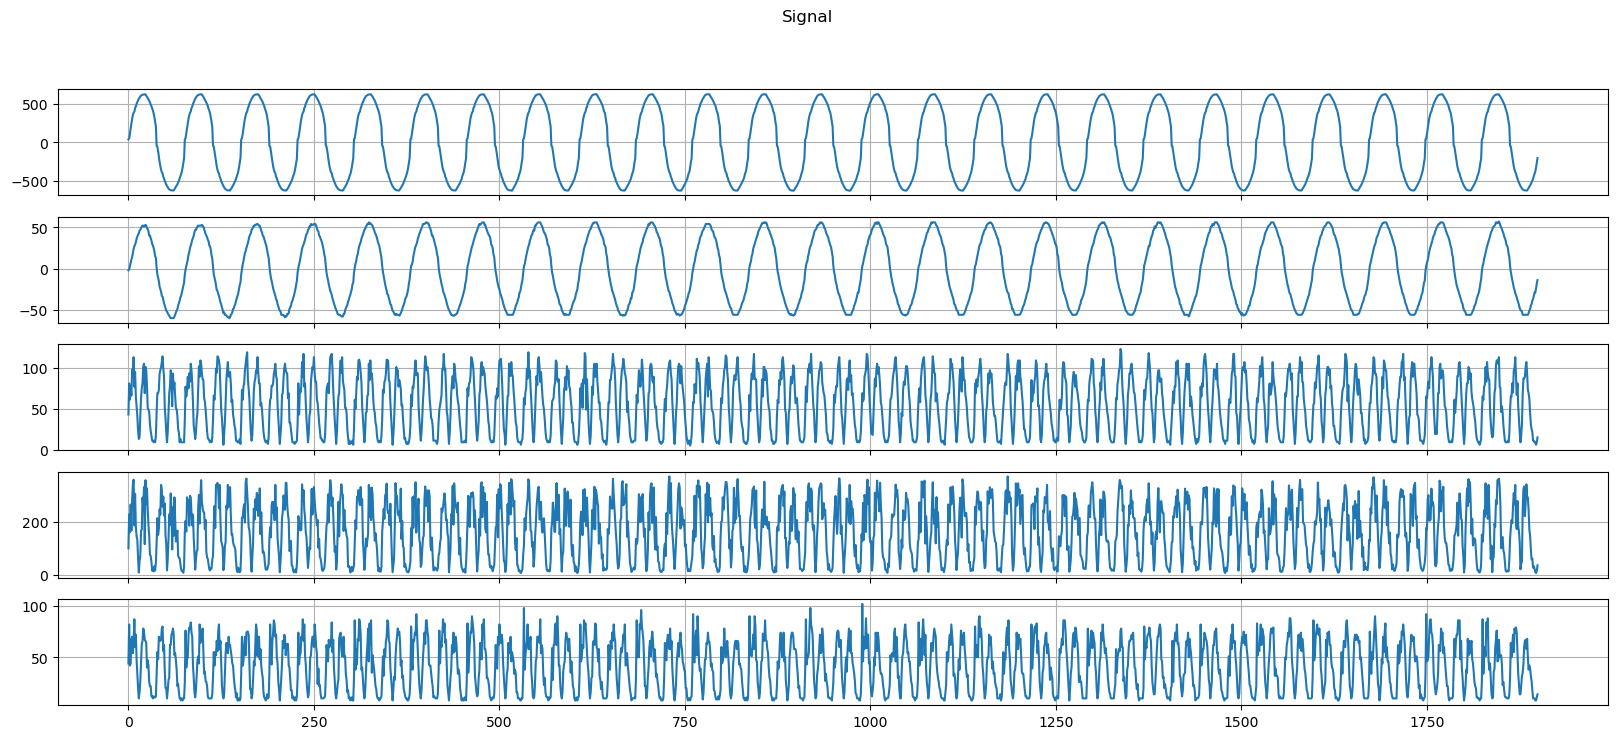

In [679]:
indice = np.random.randint(0, data_test.shape[0])
affichage_data(data_test[indice])

# Le faire pour tous les sous-dossier d'un dossier

In [636]:
dossier_avec_tous_les_dos = "Cluster Signaux"

In [641]:
for doss in os.listdir(dossier_avec_tous_les_dos):
    
    sous_doss = os.path.join(dossier_avec_tous_les_dos, doss)

    clean_dossier(sous_doss)

    data_sous_doss = generate_data(sous_doss, seq_len=seq_len)

    for indice in tqdm(range(data_sous_doss.shape[0])):
        norms = calculate_norms(data_sous_doss[indice])
        type = get_type(norms)

        path_to_save = os.path.join(sous_doss, type)

        sauvegarde_signaux(data_sous_doss[indice], folder_path.split('/')[-1], path_to_save)    

100%|██████████| 69/69 [00:00<00:00, 1213.83it/s]
